In [11]:
import sys
from glob import glob

import h5py
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [12]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import preprocess_utils as pu

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [14]:
import importlib
importlib.reload(du)

<module 'data_utils' from '/glade/u/home/ksha/NCAR/libs/data_utils.py'>

In [15]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]

In [ ]:
preserve_inds = [4, 5, 6, 15, 16]

# allocate output
grid_shape_3km = lon_3km.shape
grid_shape_72km = lon_72km.shape

data_3km = np.zeros((12,)+grid_shape_3km)
data_72km = np.zeros((12,)+grid_shape_72km)

for y in range(2010, 2021):
    
    # Year info
    year_int = int(y)
    year = str(year_int)
    
    # Raw tornado files
    file_torn = sorted(glob(report_dir+'{}_torn.csv'.format(year)))[0]
    
    # import csv to pandas and then np.array
    df = pd.read_csv(file_torn)
    temp_array = df.iloc[:, preserve_inds].values
    
    # datetime and timezone processing
    L = len(temp_array)
    temp_tz = temp_array[:, 2]
    temp_dt_list = []
    flag_badboy = False
    
    for i in range(L):
        try:
            # the string can be converted to datetime object
            temp_localtime = datetime.strptime(temp_array[i, 0]+'|'+temp_array[i, 1], '%Y-%m-%d|%H:%M:%S')
            flag_badboy = False
        except:
            # the string cannot be converted; typically a "?"
            temp_localtime = np.nan
            flag_badboy = True
            
        # adjust timezones to UTC/GMT 
        if flag_badboy is False:
            temp_tz = temp_array[i, 2]
            if temp_tz == 3:
                temp_localtime = temp_localtime + timedelta(hours=6) # <--- !!! "3" means CST
            elif temp_tz == 9:
                temp_localtime = temp_localtime # "9" means GMT
            else:
                temp_localtime = np.nan # otherwise doint know
            
        temp_dt_list.append(temp_localtime)
    
    # Insert in-situ reports into hourly, gridded data frames    
    ## convert slat slon to domain indices
    
    slon = temp_array[:, 4]
    slat = temp_array[:, 3]
    flag_pick = np.logical_and(slon<-20, slat>5)
    slon = slon[flag_pick]
    slat = slat[flag_pick]
    L = len(slon)
    
    indx_3km, indy_3km = du.grid_search(lon_3km, lat_3km, slon, slat)
    indx_72km, indy_72km = du.grid_search(lon_72km, lat_72km, slon, slat)
    
#     if du.is_leap_year(year_int):
#         N_days = 366
#     else:
#         N_days = 365
#     N_hours = N_days*24 + 6 # +6 because timezone diff can cross years

    #date_ref = datetime(year_int, 1, 1, 0, 0)

    #ind_positive_hrs_dup = []

    for i in range(L):
        
        # the time of a single record
        temp_datetime = temp_dt_list[i]
        temp_ind_month = temp_datetime.month - 1
        
        #dt_diff = temp_datetime - date_ref
        #hr_diff = int(divmod(dt_diff.total_seconds(), 3600)[0])
        
        data_3km[temp_ind_month, indx_3km[i], indy_3km[i]] += 1.0
        data_72km[temp_ind_month, indx_72km[i], indy_72km[i]] += 1.0
        
        #ind_positive_hrs_dup.append(hr_diff)

    #ind_positive_hrs_dup = np.array(ind_positive_hrs_dup)
    #ind_positive_hrs = np.unique(ind_positive_hrs_dup)

In [ ]:
from scipy.ndimage import gaussian_filter

In [53]:
grid_shape = lon_3km.shape

out = np.empty((12,)+grid_shape)

for i in range(12):
    temp = du.nearest_wraper(lon_72km, lat_72km, data_72km[i, ...], lon_3km, lat_3km)
    out[i, ...] = gaussian_filter(temp, sigma=12)

In [54]:
out = out / 5.5

In [55]:
save_dir = '/glade/work/ksha/NCAR/'
tuple_save = (lon_3km, lat_3km, out)
label_save = ['lon_3km', 'lat_3km', 'clim']
du.save_hdf5(tuple_save, label_save, save_dir, 'HRRR_torn_monthly.hdf')

Save to /glade/work/ksha/NCAR/HRRR_torn_monthly.hdf


In [56]:
with h5py.File(save_dir+'HRRR_torn_monthly.hdf', 'r') as h5io:
    clim = h5io['clim'][:]

In [57]:
clim[5, ...].shape

(1059, 1799)

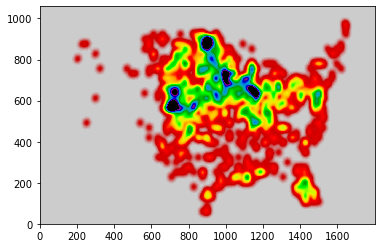

In [58]:
plt.pcolormesh(clim[5, ...], vmin=0, vmax=1.5, cmap=plt.cm.nipy_spectral_r)

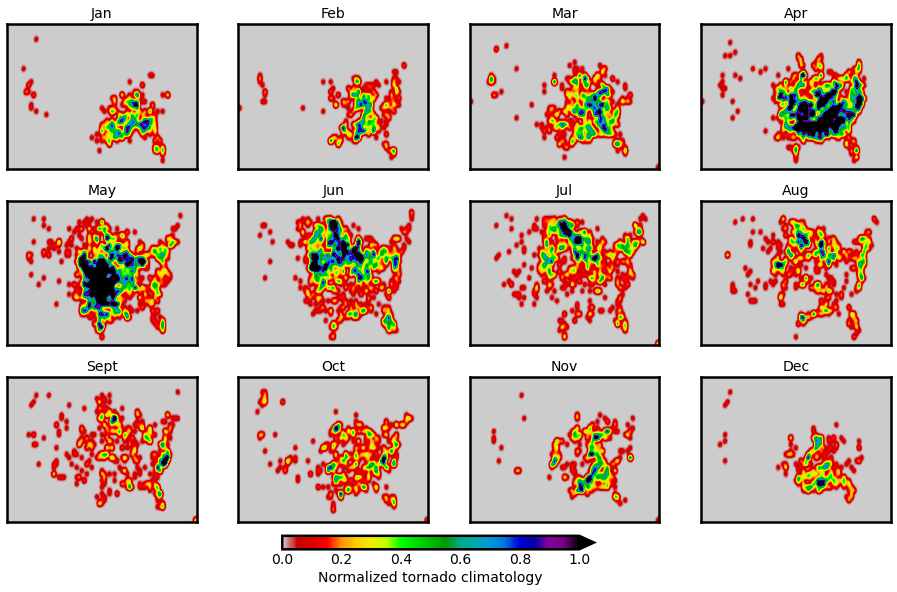

In [59]:
fig = plt.figure(figsize=(13, 7.5))
gs = gridspec.GridSpec(3, 4, height_ratios=[1,]*3, width_ratios=[1,]*4)
ax00 = plt.subplot(gs[0, 0]); ax01 = plt.subplot(gs[0, 1]); ax02 = plt.subplot(gs[0, 2])
ax10 = plt.subplot(gs[0, 3]); ax11 = plt.subplot(gs[1, 0]); ax12 = plt.subplot(gs[1, 1])
ax20 = plt.subplot(gs[1, 2]); ax21 = plt.subplot(gs[1, 3]); ax22 = plt.subplot(gs[2, 0])
ax30 = plt.subplot(gs[2, 1]); ax31 = plt.subplot(gs[2, 2]); ax32 = plt.subplot(gs[2, 3])
plt.tight_layout()

AX = [ax00, ax01, ax02, ax10, ax11, ax12, ax20, ax21, ax22, ax30, ax31, ax32]
mons = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

for i in range(12):
    ax = AX[i]
    ax = gu.ax_decorate_box(ax)
    CS = ax.pcolormesh(out[i, ...], vmin=0, vmax=1.0, cmap=plt.cm.nipy_spectral_r)
    ax.set_title(mons[i], fontsize=14)
    
ax_base = fig.add_axes([0.33, -0.025, 0.333, 0.05])
[j.set_linewidth(0.0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, height='50%', width='100%', borderpad=0, loc=2)
CBar = plt.colorbar(CS, orientation='horizontal', extend='max', cax=cax)
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Normalized tornado climatology', fontsize=14)
CBar.outline.set_linewidth(2.5)

In [ ]:
np.max(out)

7.090909090909091